# Example 3:  Heat transport in a two qubit machine with underdamped enviroments

This example provides the necessary code to reproduce the calculations from example 2 in [2](https://arxiv.org/abs/2506.22346), where the Hamiltonian is given by

\begin{align}
     H &= \underbrace{\frac{\omega_{c}}{2} \sigma^{(c)}_{z} + \frac{\Delta}{2} \sigma^{(c)}_{x}
     +\frac{\omega_{h}}{2} \sigma^{(h)}_{z} 
     + g \sigma^{(c)}_{x} \sigma^{(h)}_{x}}_{H_S} + \underbrace{\sum_{k,\alpha=h,c} \omega^{(\alpha)}_{k} a_{k}^{(\alpha)\dagger} a^{(\alpha)}_{k}}_{H_B} 
     + \underbrace{\sum_{k,\alpha=h,c} g_k \sigma^{(\alpha)}_{x} (a_{k}+a_{k}^{\dagger})}_{H_I}.
\end{align}


We first begin by importing the necessary packages

In [ ]:
import qutip as qt
import numpy as np
from qutip.core.environment import UnderDampedEnvironment
from nmm.redfield import redfield
from nmm import csolve
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import HEOMSolver, BathExponent
from time import time
import matplotlib.pyplot as plt

This next block of code defines how to compute heat currents, part of it is directly adapted from the QuTiP tutorial about heat transport in HEOM

In [2]:
def bath_heat_current(bath_tag, ado_state, hamiltonian, coupling_op):
    """
    Bath heat current from the system into the heat bath with the given tag.

    Parameters
    ----------
    bath_tag : str, tuple or any other object
        Tag of the heat bath corresponding to the current of interest.

    ado_state : HierarchyADOsState
        Current state of the system and the environment (encoded in the ADOs).

    hamiltonian : Qobj
        System Hamiltonian at the current time.

    coupling_op : Qobj
        System coupling operator at the current time.

    delta : float
        The prefactor of the \\delta(t) term in the correlation function (the
        Ishizaki-Tanimura terminator).
    Taken from the Qutip tutorials
    """
    l1_labels = ado_state.filter(level=1, tags=[bath_tag])
    a_op = 1j * (hamiltonian * coupling_op - coupling_op * hamiltonian)

    result = 0
    cI0 = 0  # imaginary part of bath auto-correlation function (t=0)
    for label in l1_labels:
        [exp] = ado_state.exps(label)
        result += exp.vk * (coupling_op * ado_state.extract(label)).tr()

        if exp.type == BathExponent.types["I"]:
            cI0 += exp.ck
        elif exp.type == BathExponent.types["RI"]:
            cI0 += exp.ck2

    result -= 2 * cI0 * (coupling_op * coupling_op * ado_state.rho).tr()
    return result


def system_heat_current(bath_tag, ado_state, hamiltonian, coupling_op):
    """
    System heat current from the system into the heat bath with the given tag.

    Parameters
    ----------
    bath_tag : str, tuple or any other object
        Tag of the heat bath corresponding to the current of interest.

    ado_state : HierarchyADOsState
        Current state of the system and the environment (encoded in the ADOs).

    hamiltonian : Qobj
        System Hamiltonian at the current time.

    coupling_op : Qobj
        System coupling operator at the current time.

    delta : float
        The prefactor of the \\delta(t) term in the correlation function (the
        Ishizaki-Tanimura terminator).
    Taken from the Qutip tutorials
    """
    l1_labels = ado_state.filter(level=1, tags=[bath_tag])
    a_op = 1j * (hamiltonian * coupling_op - coupling_op * hamiltonian)

    result = 0
    for label in l1_labels:
        result += (a_op * ado_state.extract(label)).tr()

    return result


def rotation(data, t, Hsys):
    try:
        rotated = [
            (-1j * Hsys * t[i]).expm() * data[i] * (1j * Hsys * t[i]).expm()
            for i in range(len(t))
        ]
    except:
        rotated = [
            (-1j * Hsys * t[i]).expm()
            * qt.Qobj(data[i], dims=Hsys.dims)
            * (1j * Hsys * t[i]).expm()
            for i in range(len(t))
        ]

    return rotated


def D(cops, state):
    return sum(
        [
            i * state * i.dag() - (i.dag() * i * state + state * i.dag() * i) / 2
            for i in cops
        ]
    )


def master_currents_nm(Hsys, Q1, tlist, bath1corr, result_cum, result_red, ls=False):
    rdj1 = redfield(
        Hsys=Hsys,
        baths=[bath1corr],
        t=tlist,
        Qs=[Q1],
        eps=1e-8,
        matsubara=True,
        ls=ls,
        picture="S",
    )
    rdj1.prepare_interpolated_generators()
    rdj11 = [rdj1.interpolated_generator(i) for i in tlist]
    j1cum = [
        (
            (rdj11[i] @ result_cum[i].full().flatten()).reshape(4, 4) @ Hsys.full()
        ).trace()
        for i in range(len(tlist))
    ]
    j1red = [
        ((rdj11[i] @ result_red[i].flatten()).reshape(4, 4) @ Hsys.full()).trace()
        for i in range(len(tlist))
    ]
    cum1 = csolve(
        Hsys=Hsys,
        t=tlist,
        baths=[bath1corr],
        Qs=[Q1],
        cython=False,
        matsubara=True,
        ls=ls,
    )
    cum1.generator()
    gene = np.array([(i).expm().full() for i in cum1.generators])
    gene2 = np.array([(-i).expm().full() for i in cum1.generators])
    dK_dt = np.gradient(gene, tlist, axis=0)
    dK_dt[0] = gene[0] * 0
    gene_diff = [dK_dt[i] @ gene2[i] for i in range(len(tlist))]
    j1cum2 = [
        (
            (gene_diff[i] @ result_cum[i].full().flatten()).reshape(4, 4) @ Hsys.full()
        ).trace()
        for i in range(len(tlist))
    ]
    return (
        j1cum,
        j1red,
        j1cum2,
    )  # j1cum and j2cum denote both ways to compute the cumulant current as oulined in 2
    # Notice that 2 suffers from problems with numerical differentiation which we hope to get rid of using automatic
    # differentiation soon


def master_currents(Hsys, c_ops, c_ops_global, result_global, result_local):
    j1s = np.array([(Hsys * D(c_ops_global, i)).tr() for i in result_global.states])
    j1s_local = np.array([(Hsys * D(c_ops, i)).tr() for i in result_local.states])
    return j1s_local, j1s

We now specify the parameters for the simulation as well as the initial state

In [3]:
w = 1
Delta = 1
lam = 0.05
T1 = 0.01
T2 = 2
g = 0.5
H1 = w / 2 * qt.tensor(qt.sigmaz(), qt.identity(2))
H2 = (w) / 2 * qt.tensor(qt.identity(2), qt.sigmaz())
H1T = Delta / 2 * qt.tensor(qt.sigmax(), qt.identity(2))
H12 = g * qt.tensor(qt.sigmax(), qt.sigmax())
Hsys = H1 + H2 + H12 + H1T
wc1 = 1 * w
wc2 = 1 * w
w0 = 2 * w
# Coupling operators
Q1 = qt.tensor(qt.sigmax(), qt.identity(2))
Q2 = qt.tensor(qt.identity(2), qt.sigmax())

# qubit-qubit and qubit-bath coupling strengths
lam1 = lam * np.pi * w  # bath1
lam2 = lam * np.pi * w  # bath2
# choose arbitrary initial state
rho0 = qt.Qobj([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
rho0.dims = Hsys.dims
# simulation time span
t = np.linspace(0, 80, 5000)
bath1 = UnderDampedEnvironment(T=T1, lam=lam1, gamma=wc1, w0=w0)
bath1corr, finfo1 = bath1.approx_by_cf_fit(
    t, tag="bath 1", Ni_max=1, Nr_max=4, maxfev=1e8, target_rmse=None
)
print(finfo1["summary"])

bath2 = UnderDampedEnvironment(T=T2, lam=lam2, gamma=wc2, w0=w0)
bath2corr, finfo2 = bath2.approx_by_cf_fit(
    t, tag="bath 2", Ni_max=1, Nr_max=4, maxfev=1e8, target_rmse=None
)
print(finfo2["summary"])

options = {
    "nsteps": 15000,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-12,
    "atol": 1e-12,
}

/home/Gerardo/qutip_new/qutip/core/environment.py:753: FutureWarning: The API has changed. Please use approximate("cf", ...) instead of approx_by_cf_fit(...).
  warnings.warn('The API has changed. Please use approximate("cf", ...)'
/home/Gerardo/qutip_new/qutip/utilities.py:56: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Correlation function fit:

Result of fitting the real part of                        |Result of fitting the imaginary part                       
the correlation function with 4 terms:                    |of the correlation function with 1 terms:                  
                                                          |                                                           
 Parameters|   ckr    |   vkr    |  vki                   | Parameters|   ckr    |   vkr    |  vki                    
 1         |-4.19e-05 |-2.11e-01 |2.25e-06                | 1         |-6.37e-03 |-5.00e-01 |1.94e+00                 
 2         |-4.94e-04 |-1.05e+00 |1.89e-05                |                                                           
 3         |-4.51e-04 |-4.67e+00 |2.71e-03                |A RMSE of  4.58e-07 was obtained for the the imaginary part
 4         | 6.34e-03 |-4.99e-01 |1.94e+00                |of the correlation function.                               
                     

Similarly to the other examples we now perform each of the simulations with the different methods

In [4]:
options = {
    "nsteps": 15000,
    "store_states": True,
    "store_ados": True,
    "rtol": 1e-8,
    "atol": 1e-8,
    "method": "bdf",
}
tlist = np.linspace(0, 100 / bath1.lam, 5000)
start = time()
solver = HEOMSolver(
    Hsys, [(bath1corr, Q1), (bath2corr, Q2)], max_depth=4, options=options
)  # this is slow
result = solver.run(rho0, tlist)
end_heom = time()

10.0%. Run time:  49.22s. Est. time left: 00:00:07:22
20.0%. Run time:  97.13s. Est. time left: 00:00:06:28
30.0%. Run time: 144.24s. Est. time left: 00:00:05:36
40.0%. Run time: 188.27s. Est. time left: 00:00:04:42
50.0%. Run time: 229.63s. Est. time left: 00:00:03:49
60.0%. Run time: 274.37s. Est. time left: 00:00:03:02
70.0%. Run time: 317.54s. Est. time left: 00:00:02:15
80.0%. Run time: 357.86s. Est. time left: 00:00:01:29
90.0%. Run time: 398.56s. Est. time left: 00:00:00:44
100.0%. Run time: 438.48s. Est. time left: 00:00:00:00
Total run time: 438.49s


In [5]:
start2 = time()
cum = csolve(
    Hsys=Hsys,
    t=tlist,
    baths=[bath1corr, bath2corr],
    Qs=[Q1, Q2],
    cython=False,
    matsubara=True,
    ls=False,
)
result_cum = cum.evolution(rho0)
result_cum2 = rotation(result_cum, tlist, Hsys=Hsys)
end2 = time()

Calculating time dependent generators: 100%|████████████████████████████████████████████████| 25/25 [00:01<00:00, 20.23it/s]
Computing Exponential of Generators . . . .: 5000it [00:01, 2700.90it/s]


In [6]:
start3 = time()
cum_int = csolve(
    Hsys=Hsys,
    t=tlist,
    baths=[bath1, bath2],
    Qs=[Q1, Q2],
    cython=False,
    matsubara=False,
    ls=False,
)
result_cum_int = cum_int.evolution(rho0)
result_cum2_int = rotation(result_cum_int, tlist, Hsys=Hsys)
end3 = time()

Calculating time dependent generators: 100%|████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.73it/s]
Computing Exponential of Generators . . . .: 5000it [00:01, 2737.73it/s]


In [7]:
start4 = time()
cum_ls = csolve(
    Hsys=Hsys,
    t=tlist,
    baths=[bath1corr, bath2corr],
    Qs=[Q1, Q2],
    cython=False,
    matsubara=True,
    ls=True,
)
result_cum_ls = cum.evolution(rho0)
result_cum2_ls = rotation(result_cum, tlist, Hsys=Hsys)
end4 = time()

Calculating time dependent generators: 100%|████████████████████████████████████████████████| 25/25 [00:01<00:00, 20.11it/s]
Computing Exponential of Generators . . . .: 5000it [00:01, 2627.71it/s]


In [8]:
start5 = time()
rd2 = redfield(
    Hsys=Hsys,
    baths=[bath1corr, bath2corr],
    t=tlist,
    Qs=[Q1, Q2],
    eps=1e-8,
    matsubara=True,
    ls=False,
    picture="S",
)
result_red = rd2.evolution(rho0, method="BDF")
end5 = time()

Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:6.34388542175293
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.020324230194091797
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:34.58197641372681


In [9]:
start6 = time()
rd2_ls = redfield(
    Hsys=Hsys,
    baths=[bath1corr, bath2corr],
    t=tlist,
    Qs=[Q1, Q2],
    eps=1e-8,
    matsubara=True,
    ls=True,
    picture="S",
)
result_red_ls = rd2_ls.evolution(rho0, method="BDF")
end6 = time()

Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:11.740429639816284
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.020132064819335938
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:34.497650384902954


In [10]:
start7 = time()
rd2_ls = redfield(
    Hsys=Hsys,
    baths=[bath1, bath2],
    t=tlist,
    Qs=[Q1, Q2],
    eps=1e-2,
    matsubara=False,
    ls=False,
    picture="S",
)
result_red_ls_int = rd2_ls.evolution(
    rho0, method="BDF"
)  # this is slow, Feel free to comment this and skip this calculation
end7 = time()

Started integration and Generator Calculations


/home/Gerardo/NonMarkovianMethods/nmm/redfield/redfield.py:85: RuntimeWarning: overflow encountered in exp
  return 1 / (np.exp(w / bath.T)-1)


Finished integration and Generator Calculations
Computation Time:1215.9020819664001
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.019315242767333984
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:34.471312284469604


In [11]:
start8 = time()
global_one = cum.jump_operators(Q1)  # Global Jump Operators for Bath 1
global_two = cum.jump_operators(Q2)  # Global Jump Operators for Bath 2
c_ops_global1 = [
    qt.Qobj((np.sqrt(bath1.power_spectrum(k)) * v).data, dims=Hsys.dims)
    for k, v in global_one.items()
]
c_ops_global2 = [
    qt.Qobj((np.sqrt(bath2.power_spectrum(k)) * v).data, dims=Hsys.dims)
    for k, v in global_two.items()
]
c_ops2 = c_ops_global2 + c_ops_global1
result_lindblad_global2 = qt.mesolve(
    Hsys, rho0, tlist, c_ops2, options={"rtol": 1e-12, "atol": 1e-12}
)
end8 = time()

In [12]:
# LOCAL GKLS SIMULATION
start9 = time()
options = {"nsteps": 150000, "store_states": True, "rtol": 1e-12, "atol": 1e-12}
H1_local = w / 2 * qt.sigmaz() + Delta / 2 * qt.sigmax()
H2_local = w / 2 * qt.sigmaz()
local_get1 = csolve(Hsys=H1_local, t=0, baths=[], Qs=[], cython=False, matsubara=True)
local_one = local_get1.jump_operators(qt.sigmax())
local_get2 = csolve(Hsys=H2_local, t=0, baths=[], Qs=[], cython=False, matsubara=True)
local_two = local_get2.jump_operators(qt.sigmax())
c_ops_local1 = [
    qt.Qobj(
        (np.sqrt(bath1.power_spectrum(k)) * qt.tensor(v, qt.identity(2))).data,
        dims=Hsys.dims,
    )
    for k, v in local_one.items()
]
c_ops_local2 = [
    qt.Qobj(
        (np.sqrt(bath2.power_spectrum(k)) * qt.tensor(qt.identity(2), v)).data,
        dims=Hsys.dims,
    )
    for k, v in local_two.items()
]
c_ops = c_ops_local1 + c_ops_local2
result_lindblad = qt.mesolve(Hsys, rho0, tlist, c_ops, options=options)
end9 = time()

We now calculate the heat currents

In [13]:
j1 = np.array([system_heat_current("bath 1", i, Hsys, Q1) for i in result.ado_states])
j2 = np.array([system_heat_current("bath 2", i, Hsys, Q2) for i in result.ado_states])
sj1 = np.array([bath_heat_current("bath 1", i, Hsys, Q1) for i in result.ado_states])
sj2 = np.array([bath_heat_current("bath 2", i, Hsys, Q2) for i in result.ado_states])
result_arr = [i.full() for i in result.states]

In [14]:
j1_cum_ls, j1_red_ls, j1_cum2_ls = master_currents_nm(
    Hsys, Q1, tlist, bath1corr, result_cum2_ls, result_red_ls, ls=True
)
j1_cum, j1_red, j1_cum2 = master_currents_nm(
    Hsys, Q1, tlist, bath1corr, result_cum2, result_red, ls=False
)

Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:9.132726907730103
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.01956939697265625
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Calculating time dependent generators: 100%|████████████████████████████████████████████████| 81/81 [00:08<00:00,  9.56it/s]


Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:5.066476106643677
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.01968550682067871
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Calculating time dependent generators: 100%|████████████████████████████████████████████████| 81/81 [00:04<00:00, 17.50it/s]


In [15]:
j2_cum_ls, j2_red_ls, j2_cum2_ls = master_currents_nm(
    Hsys, Q2, tlist, bath2corr, result_cum2_ls, result_red_ls, ls=True
)
j2_cum, j2_red, j2_cum2 = master_currents_nm(
    Hsys, Q2, tlist, bath2corr, result_cum2, result_red, ls=False
)

Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:2.971193313598633
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.01986551284790039
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Calculating time dependent generators: 100%|████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.87it/s]


Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:1.6164255142211914
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.01972508430480957
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Calculating time dependent generators: 100%|████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.76it/s]


In [16]:
j1_local, j1_global = master_currents(
    Hsys, c_ops_local1, c_ops_global1, result_lindblad_global2, result_lindblad
)
j2_local, j2_global = master_currents(
    Hsys, c_ops_local2, c_ops_global2, result_lindblad_global2, result_lindblad
)

Finally we plot the results

/home/Gerardo/anaconda3/envs/qutip-dev/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


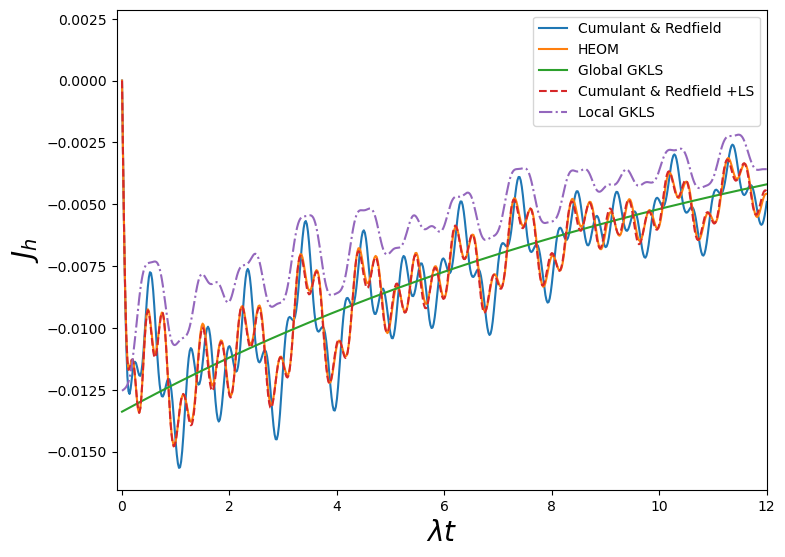

In [ ]:


fig = plt.figure(figsize=(10, 6))
plot_ax = fig.add_axes([0.1, 0.1, 0.65, 0.8])  # Main axes

# Main plot
plot_ax.plot(bath1.lam * tlist, np.array(j2_cum), label="Cumulant & Redfield")
plot_ax.plot(bath1.lam * tlist, -j2, label="HEOM")
plot_ax.plot(bath1.lam * tlist, np.array(j2_global), label="Global GKLS", zorder=2)
plot_ax.plot(
    bath1.lam * tlist, np.array(j2_cum_ls), "--", label="Cumulant & Redfield +LS"
)
plot_ax.plot(bath1.lam * tlist, np.array(j2_local), "-.", label="Local GKLS", zorder=3)


plot_ax.set_xlim(-0.1, 12)

plot_ax.set_xlabel(r"$\lambda t$", fontsize=20)
plot_ax.set_ylabel(r"$J_{h}$", fontsize=20)


plot_ax.legend(ncol=1, loc="upper right")

plt.show()

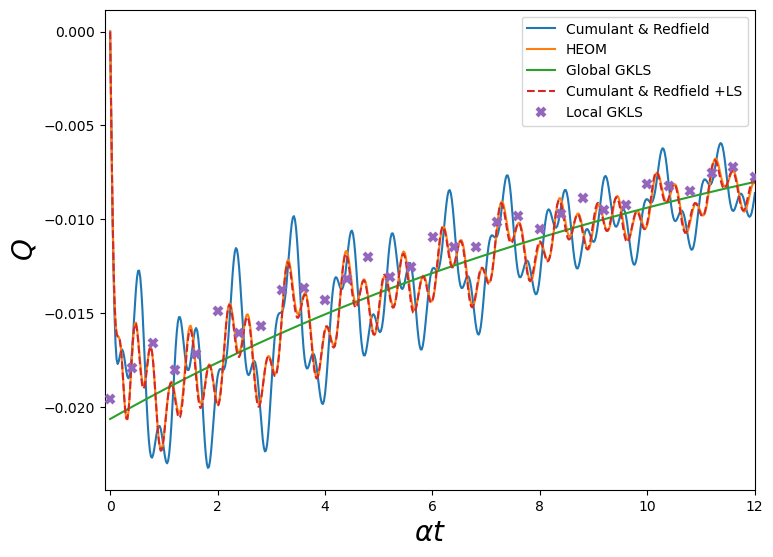

In [18]:
fig = plt.figure(figsize=(10, 6))
plot_ax = fig.add_axes([0.1, 0.1, 0.65, 0.8])  # Main axes

# Main plot
plot_ax.plot(
    bath1.lam * tlist, np.array(j2_cum) + np.array(j1_cum), label="Cumulant & Redfield"
)
plot_ax.plot(bath1.lam * tlist, -(j2 + j1), label="HEOM")
plot_ax.plot(
    bath1.lam * tlist,
    np.array(j2_global) + np.array(j1_global),
    label="Global GKLS",
    zorder=2,
)
plot_ax.plot(
    bath1.lam * tlist,
    np.array(j2_cum_ls) + np.array(j1_cum_ls),
    "--",
    label="Cumulant & Redfield +LS",
)
plot_ax.plot(
    bath1.lam * tlist,
    np.array(j2_local) + np.array(j1_local),
    marker="x",
    linestyle="None",
    label="Local GKLS",
    zorder=6,
    markevery=20,
    markeredgewidth=3,
)

plot_ax.set_xlim(-0.1, 12)

plot_ax.set_xlabel(r"$\alpha t$", fontsize=20)
plot_ax.set_ylabel(r"$Q$", fontsize=20)

plot_ax.legend(ncol=1, loc="upper right")

plt.show()

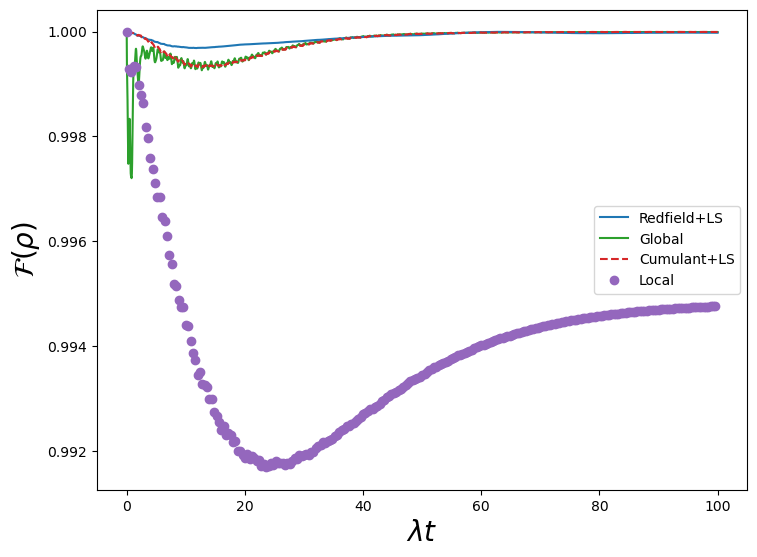

In [20]:
fig = plt.figure(figsize=(10, 6))
plot_ax = fig.add_axes([0.1, 0.1, 0.65, 0.8])  # Main axes

fid_global = [
    qt.fidelity(result.states[i], qt.Qobj(result_lindblad_global2.states[i]))
    for i in range(len(tlist))
]
fid_cum = [
    qt.fidelity(result.states[i], qt.Qobj(result_cum2_ls[i], dims=Hsys.dims))
    for i in range(len(tlist))
]
fid_red = [
    qt.fidelity(result.states[i], qt.Qobj(result_red_ls[i], dims=Hsys.dims))
    for i in range(len(tlist))
]

fid_local = [
    qt.fidelity(result.states[i], qt.Qobj(result_lindblad.states[i]))
    for i in range(len(tlist))
]

plot_ax.plot(bath1.lam * tlist, fid_red, label="Redfield+LS")
plot_ax.plot([], [], visible=False)
plot_ax.plot(bath1.lam * tlist, fid_global, label="Global", zorder=1)
plot_ax.plot(bath1.lam * tlist, fid_cum, "--", label="Cumulant+LS")
plot_ax.plot(
    bath1.lam * tlist,
    fid_local,
    label="Local",
    linestyle="None",
    marker="o",
    markevery=20,
)
plot_ax.set_xlabel(r"$\lambda t$", fontsize=20)
plot_ax.set_ylabel(r"$\mathcal{F}(\rho)$", fontsize=20)
# plt.xlim(-1,50)
# plt.ylim(0.995,1.0001)
plot_ax.legend(ncol=1, loc="center right")
plt.show()

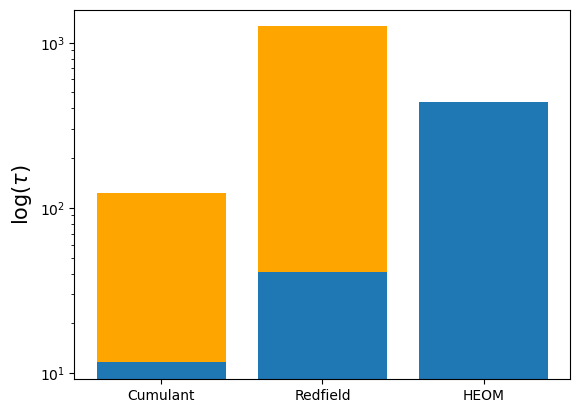

In [ ]:
methods2 = ["Cumulant", "Redfield"]
plt.bar(methods2, np.array([end3 - start3, end7 - start7]), color="orange")
methods2 = ["HEOM", "Cumulant", "Redfield"]
plt.bar(methods2, [end_heom - start, end2 - start2, end5 - start5])
plt.yscale("log")
plt.ylabel(r"$\tau$", fontsize=15)
plt.savefig("example2_timing.pdf", bbox_inches="tight")
plt.show()